In [ ]:
# data
import sklearn

from sklearn.datasets import make_circles

n_samples = 1000

X , y = make_circles(n_samples , noise = 0.03 , random_state = 42)

len(X) , len (y)



(1000, 1000)

In [ ]:
X[0:5] , y[0:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [ ]:
import pandas as pd

circles = pd.DataFrame({
    "X1" : X[: , 0  ] ,
    "X2" : X[:  ,1   ] ,
    "label" : y
})

In [ ]:
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


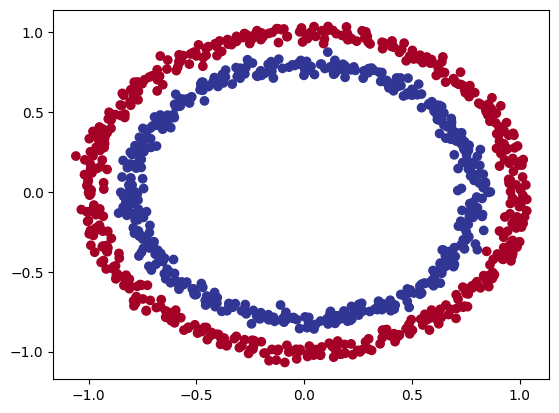

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(x = "X1" , y = "X2" , data = circles , c = "label" , cmap = plt.cm.RdYlBu)

In [ ]:
X.shape , y.shape

((1000, 2), (1000,))

In [ ]:
import torch

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
X.shape , y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [ ]:
 X.dtype , y.dtype

(torch.float32, torch.float32)

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
X_train ,   X_test , y_train ,  y_test  = train_test_split(X,y , test_size= 0.2 ,  random_state= 42  )

In [ ]:
len(X_train ) , len(y_train) , len(X_test) , len(y_test)

(800, 800, 200, 200)

In [ ]:
X_train.dtype , y_train.dtype , X_test.dtype , y_test.dtype

(torch.float32, torch.float32, torch.float32, torch.float32)

In [ ]:
import torch
from torch import nn


device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
## Model

class CircleModel(nn.Module) :
  def __init__(self) :
    super().__init__()

    self.layer_1 = nn.Linear(in_features = 2 , out_features = 5 , dtype= torch.float )
    self.layer_2  = nn.Linear(in_features = 5 , out_features = 1 , dtype = torch.float  )

  def forward(self , x ) :
    return self.layer_2(self.layer_1(x))

model_0 = CircleModel().to(device)
model_0

CircleModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
device

'cuda'

In [ ]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [ ]:
model_0.parameters()


<generator object Module.parameters at 0x7ca249c9b220>

In [ ]:
untrain_pred = model_0(X_test.to(device))
print(f"Leng of preds : {len(untrain_pred)} |  Shape of preds : {untrain_pred.shape}")
print(f"len of test samples : {len(X_test)} , shape of test samples : {X_test.shape}")
print(f"10 preds : {untrain_pred[:10]}")
print(f"10 test samples : {y_test[:10]}" )

Leng of preds : 200 |  Shape of preds : torch.Size([200, 1])
len of test samples : 200 , shape of test samples : torch.Size([200, 2])
10 preds : tensor([[ 0.5331],
        [ 0.4989],
        [ 0.1710],
        [ 0.6375],
        [-0.5461],
        [-0.5614],
        [-0.0894],
        [-0.3395],
        [ 0.2018],
        [ 0.4886]], device='cuda:0', grad_fn=<SliceBackward0>)
10 test samples : tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_0.parameters() , lr = 0.1)


In [ ]:
## accuracy
def accuracy_fn(y_true , y_pred) :
  correct = torch.eq(y_true , y_pred).sum().item()
  acc = (correct / len(y_pred))* 100
  return acc


In [ ]:
model_0.eval()
with torch.inference_mode() :
  y_logits = model_0(X_test.to(device))[:5]

y_logits

tensor([[ 0.5331],
        [ 0.4989],
        [ 0.1710],
        [ 0.6375],
        [-0.5461]], device='cuda:0')

In [ ]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6302],
        [0.6222],
        [0.5426],
        [0.6542],
        [0.3668]], device='cuda:0')

In [ ]:
torch.round(y_pred_probs)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.]], device='cuda:0')

In [ ]:
y_train.shape

torch.Size([800])

In [ ]:
y_logits.shape

torch.Size([5, 1])

In [ ]:
# train

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100


X_train , y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)


for epoch in range(epochs) :
  model_0.train()
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits , y_train)

  acc = accuracy_fn(y_true = y_train , y_pred = y_pred )

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()


  model_0.eval()

  with torch.inference_mode()  :
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits , y_test )

    test_acc = accuracy_fn(y_true = y_test , y_pred = test_pred)


  if epoch%10 == 0  :
    print(f"Epoch : {epoch} | loss : {loss}  | testLoss : {test_loss} | accuracy : {acc} | test_acc : {test_acc} ")








Epoch : 0 | loss : 0.7154455184936523  | testLoss : 0.7194469571113586 | accuracy : 50.0 | test_acc : 49.5 
Epoch : 10 | loss : 0.7052674889564514  | testLoss : 0.7094120383262634 | accuracy : 49.375 | test_acc : 52.0 
Epoch : 20 | loss : 0.7001705765724182  | testLoss : 0.7042711973190308 | accuracy : 48.75 | test_acc : 51.0 
Epoch : 30 | loss : 0.6973251104354858  | testLoss : 0.7013205289840698 | accuracy : 49.25 | test_acc : 49.0 
Epoch : 40 | loss : 0.6956503987312317  | testLoss : 0.6995158195495605 | accuracy : 49.5 | test_acc : 49.5 
Epoch : 50 | loss : 0.6946418881416321  | testLoss : 0.6983686685562134 | accuracy : 49.75 | test_acc : 48.5 
Epoch : 60 | loss : 0.6940286159515381  | testLoss : 0.6976180672645569 | accuracy : 50.24999999999999 | test_acc : 48.5 
Epoch : 70 | loss : 0.6936540007591248  | testLoss : 0.6971133947372437 | accuracy : 49.625 | test_acc : 46.0 
Epoch : 80 | loss : 0.6934240460395813  | testLoss : 0.6967641115188599 | accuracy : 50.375 | test_acc : 46.5

In [ ]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

In [ ]:
X_train.dtype , y_train.dtype , model_0.layer_1.weight.dtype , model_0.layer_1.bias.dtype

(torch.float32, torch.float32, torch.float32, torch.float32)

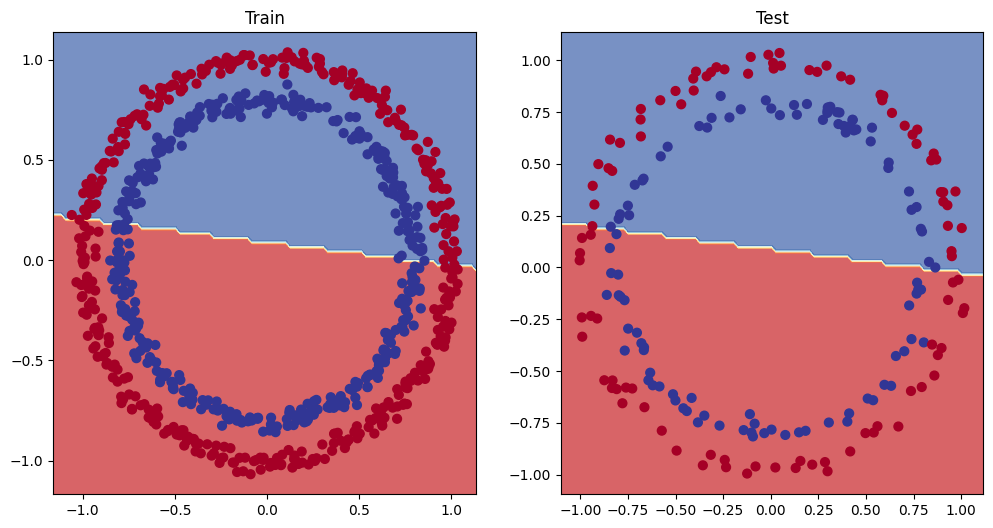

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [ ]:
## Tuned Model


class CircleModel1(nn.Module) :
  def __init__(self) :
    super().__init__()

    self.layer_1 = nn.Linear(in_features = 2 , out_features = 10 )
    self.layer_2 = nn.Linear(in_features = 10 , out_features = 10 )
    self.layer_3 = nn.Linear(in_features = 10 , out_features = 1 )


  def forward(self , x ) :
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModel1().to(device)
model_1

CircleModel1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# loss fn

loss_fn1 = torch.nn.BCEWithLogitsLoss()

# optimizer

optimizer1 = torch.optim.SGD(params = model_1.parameters() , lr = 0.01)


In [ ]:
## training & evaluation


torch.manual_seed(42)
torch.cuda.manual_seed(42)


epochs = 500

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)


for epoch in range(epochs) :
  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn1(y_logits, y_train )

  acc = accuracy_fn(y_true  = y_train , y_pred = y_pred )

  optimizer1.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()

  with torch.inference_mode()  :
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn1(test_logits , y_test)

    test_acc = accuracy_fn(y_true = y_test ,  y_pred = test_pred )

  if epoch%10 == 0 :
    print(f"epoch : {epoch} |  loss : {loss} | test_loss : {test_loss} | acc : {acc} | test_acc : {test_acc}")


epoch : 0 |  loss : 0.6939550638198853 | test_loss : 0.6926102042198181 | acc : 50.875 | test_acc : 51.0
epoch : 10 |  loss : 0.6939550638198853 | test_loss : 0.6926102042198181 | acc : 50.875 | test_acc : 51.0
epoch : 20 |  loss : 0.6939550638198853 | test_loss : 0.6926102042198181 | acc : 50.875 | test_acc : 51.0
epoch : 30 |  loss : 0.6939550638198853 | test_loss : 0.6926102042198181 | acc : 50.875 | test_acc : 51.0
epoch : 40 |  loss : 0.6939550638198853 | test_loss : 0.6926102042198181 | acc : 50.875 | test_acc : 51.0
epoch : 50 |  loss : 0.6939550638198853 | test_loss : 0.6926102042198181 | acc : 50.875 | test_acc : 51.0
epoch : 60 |  loss : 0.6939550638198853 | test_loss : 0.6926102042198181 | acc : 50.875 | test_acc : 51.0
epoch : 70 |  loss : 0.6939550638198853 | test_loss : 0.6926102042198181 | acc : 50.875 | test_acc : 51.0
epoch : 80 |  loss : 0.6939550638198853 | test_loss : 0.6926102042198181 | acc : 50.875 | test_acc : 51.0
epoch : 90 |  loss : 0.6939550638198853 | test_

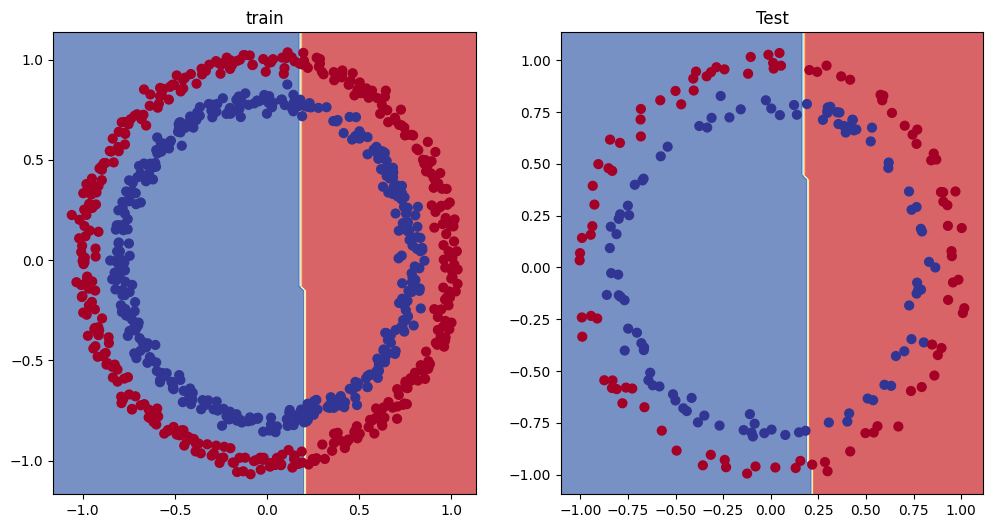

In [ ]:
## plot decision boundary

plt.figure(figsize =(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_1 , X_train , y_train )
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1 , X_test , y_test)

In [ ]:
## Model3

class CircleModel2(nn.Module) :
  def __init__(self) :
    super().__init__()

    self.layer_1 = nn.Linear(in_features = 2 , out_features = 10 )
    self.layer_2 = nn.Linear(in_features = 10 , out_features = 10 )
    self.layer_3 = nn.Linear(in_features = 10 , out_features = 10 )
    self.layer_4 = nn.Linear(in_features= 10 , out_features  =1 )

    self.relu = nn.ReLU()

  def forward(self ,x ) :
    return  self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))

model_3 = CircleModel2().to(device)
model_3

CircleModel2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=10, bias=True)
  (layer_4): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# loss & optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters() , lr = 0.01)




In [ ]:
torch.manual_seed(42)

torch.cuda.manual_seed(42)


X_train, y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)


epochs = 100

for epoch in range(epochs) :
  model_3.train()

  y_logits = model_3(X_train).squeeze()

  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits , y_train )
  acc = accuracy_fn(y_true = y_train , y_pred = y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()


  model_3.eval()

  with torch.inference_mode() :
    test_logits = model_3(X_test).squeeze()

    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss  = loss_fn(test_logits , y_test)

    test_acc = accuracy_fn(y_true = y_test , y_pred = test_pred )

  if epoch%10 == 0 :
    print(f"epoch : {epoch} | loss : {loss} | test_loss : {test_loss} | acc : {acc} | testAcc : {test_acc}")




epoch : 0 | loss : 0.6981476545333862 | test_loss : 0.6977993845939636 | acc : 50.0 | testAcc : 50.0
epoch : 10 | loss : 0.6978262662887573 | test_loss : 0.6974779963493347 | acc : 50.0 | testAcc : 50.0
epoch : 20 | loss : 0.6975229978561401 | test_loss : 0.6971747279167175 | acc : 50.0 | testAcc : 50.0
epoch : 30 | loss : 0.6972370147705078 | test_loss : 0.6968886256217957 | acc : 50.0 | testAcc : 50.0
epoch : 40 | loss : 0.6969673037528992 | test_loss : 0.6966190338134766 | acc : 50.0 | testAcc : 50.0
epoch : 50 | loss : 0.6967127919197083 | test_loss : 0.69636470079422 | acc : 50.0 | testAcc : 50.0
epoch : 60 | loss : 0.6964729428291321 | test_loss : 0.6961247324943542 | acc : 50.0 | testAcc : 50.0
epoch : 70 | loss : 0.696246325969696 | test_loss : 0.6958981156349182 | acc : 50.0 | testAcc : 50.0
epoch : 80 | loss : 0.6960322260856628 | test_loss : 0.6956841349601746 | acc : 50.0 | testAcc : 50.0
epoch : 90 | loss : 0.6958303451538086 | test_loss : 0.6954820156097412 | acc : 50.0 |

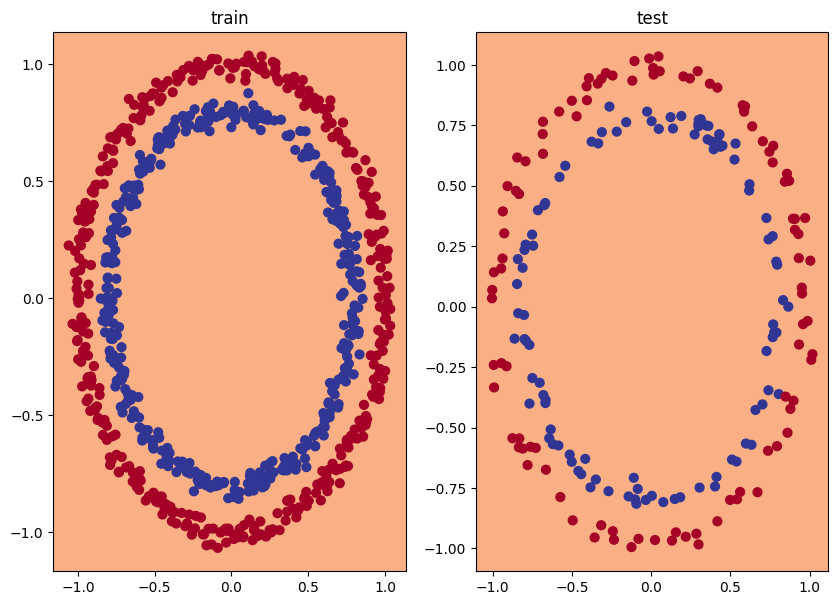

In [ ]:
plt.figure(figsize = (10,7))

plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_3 , X_train , y_train )

plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_3 , X_test , y_test)

*Note :*



Need to improve the model 🥲🥲🥲

## ***MULTI CLASS***


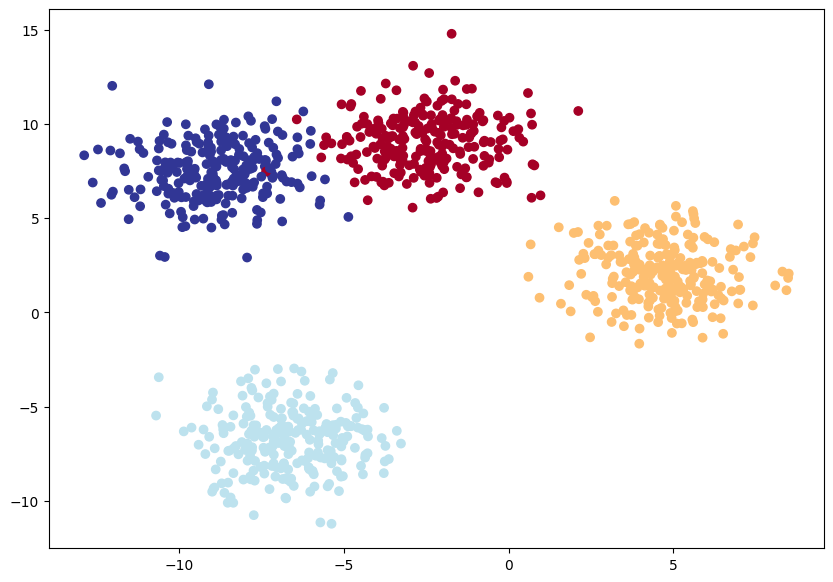

In [ ]:
import torch
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob , y_blob = make_blobs(n_samples = 1000 , n_features = NUM_FEATURES,
                             centers= NUM_CLASSES , cluster_std = 1.5 ,
                             random_state= RANDOM_SEED )

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_train , X_test , y_train , y_test = train_test_split(X_blob , y_blob , test_size= 0.2 , random_state= RANDOM_SEED )


plt.figure(figsize = (10,7))

plt.scatter(X_blob[:, 0 ] , X_blob[: ,1] , c = y_blob , cmap = plt.cm.RdYlBu)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class BlobModel(nn.Module) :
  def __init__(self , input_features , output_features, hidden_units = 8 ) :
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units) ,
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_features)
    )
  def forward(self ,x  ) :
    return self.linear_layer_stack(x)


model_4 = BlobModel(input_features = 2,
                    output_features= 4,
                    hidden_units= 8).to(device)



In [ ]:
torch.unique(y_blob)

tensor([0, 1, 2, 3])

In [ ]:
X_train.shape , y_train[:5 ]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model_4.parameters(), lr = 0.1)


In [ ]:
X_test.device

device(type='cpu')

In [ ]:
with torch.inference_mode() :
  y_logits = model_4(X_test.to(device))

In [ ]:
y_pred_prob = torch.softmax(y_logits, dim =1 )
print(y_logits[:5])
print(y_pred_prob[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [ ]:
y_preds[:10]

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [ ]:
y_preds  = torch.argmax(y_pred_prob, dim  =1 )
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [ ]:
X_train.shape , y_train.shape  , X_test.shape , y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

In [ ]:
y_logits.shape , test_logits.shape

(torch.Size([200, 4]), torch.Size([200]))

In [ ]:
torch.manual_seed(42)

torch.cuda.manual_seed(42)


X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)


eppochs = 100


for epoch in range(epochs) :

  model_4.train()

  y_logits = model_4(X_train )
  y_pred =  torch.softmax(y_logits, dim =1 ).argmax(dim =1 )

  loss = loss_fn(y_logits , y_train)
  acc = accuracy_fn(y_train , y_pred )

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_4.eval()

  with torch.inference_mode() :
    test_logit = model_4(X_test)
    test_pred = torch.softmax(test_logit,  dim = 1 ).argmax(dim =1 )

    test_loss = loss_fn(test_logit , y_test)
    test_acc = accuracy_fn(y_test , test_pred)

  if epoch%10 == 0 :
    print(f"epoch : {epoch} | loss : {loss} | testLoss : {test_loss} | acc : {acc} | testAcc : {test_acc}")





epoch : 0 | loss : 0.9801270961761475 | testLoss : 0.9413163661956787 | acc : 61.375 | testAcc : 64.0
epoch : 10 | loss : 0.5979259610176086 | testLoss : 0.6128042936325073 | acc : 97.75 | testAcc : 98.0
epoch : 20 | loss : 0.38755476474761963 | testLoss : 0.3907053768634796 | acc : 98.875 | testAcc : 100.0
epoch : 30 | loss : 0.2193664163351059 | testLoss : 0.20880919694900513 | acc : 99.25 | testAcc : 99.5
epoch : 40 | loss : 0.09758308529853821 | testLoss : 0.08844441175460815 | acc : 99.25 | testAcc : 99.5
epoch : 50 | loss : 0.06198401376605034 | testLoss : 0.0542694553732872 | acc : 99.25 | testAcc : 99.5
epoch : 60 | loss : 0.04873639717698097 | testLoss : 0.0409502312541008 | acc : 99.25 | testAcc : 99.5
epoch : 70 | loss : 0.04189472272992134 | testLoss : 0.0336943082511425 | acc : 99.25 | testAcc : 99.5
epoch : 80 | loss : 0.03763366863131523 | testLoss : 0.02912113629281521 | acc : 99.25 | testAcc : 99.5
epoch : 90 | loss : 0.03477511927485466 | testLoss : 0.0261153466999530

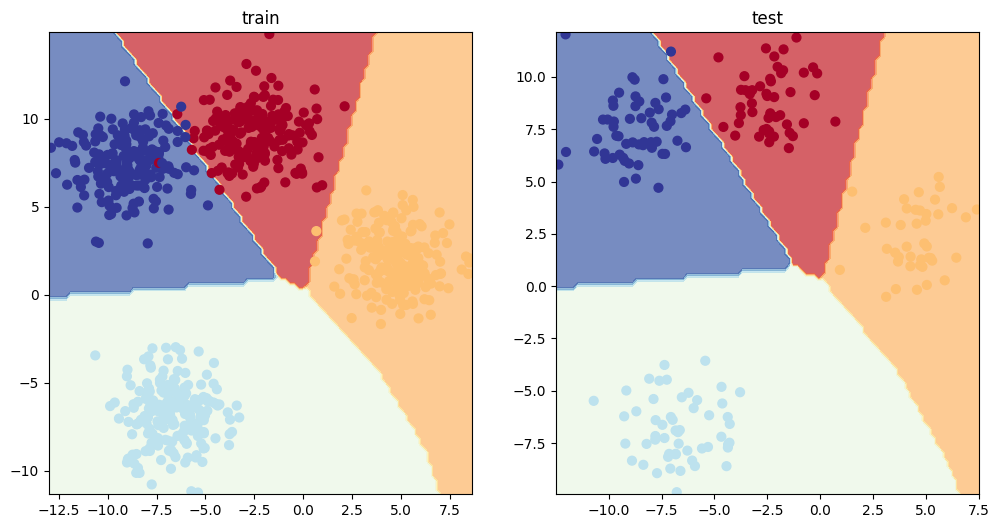

In [ ]:
plt.figure(figsize = (12, 6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_4 , X_train , y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_4 , X_test , y_test)